## Getting started with emu-sv

This tutorial shows how to use emu-sv as a Pulser backend to run a pulse sequence and extract observables. We emulate the preparation of an antiferromagnetic (AFM) state on a 1D ring of atoms using state vector simulation.

Emu-sv is a state-vector emulator designed for medium-sized systems (~25 qubits), providing exact simulation of neutral-atom quantum hardware. For larger systems, see the [emu-mps tutorial](../../../emu_mps/notebooks/getting_started) which uses Matrix Product States.

To illustrate the simulation of sequences, let us study a simple one-dimensional system with periodic boundary conditions (a ring of atoms):

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pulser

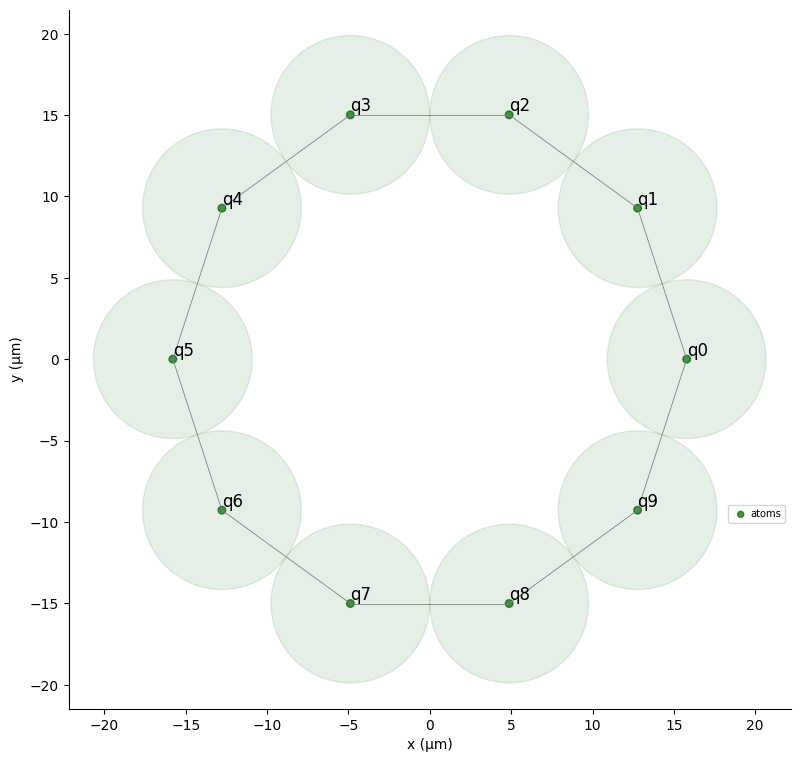

In [2]:
# Setup
L = 10

Omega_max = 2.3 * 2 * np.pi
U = Omega_max / 2.3

delta_0 = -3 * U
delta_f = 1 * U

t_rise = 2000
t_fall = 2000
t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 5000

# Define a ring of atoms distanced by a blockade radius distance:
R_interatomic = pulser.MockDevice.rydberg_blockade_radius(U)
coords = (
    R_interatomic
    / (2 * np.sin(np.pi / L))
    * np.array(
        [
            (np.cos(theta * 2 * np.pi / L), np.sin(theta * 2 * np.pi / L))
            for theta in range(L)
        ]
    )
)

# ring, periodic register
reg = pulser.Register.from_coordinates(coords, prefix="q")
# or try open boundaries
#reg = pulser.Register.rectangle(1,L,spacing=R_interatomic/1.2, prefix="q")

reg.draw(blockade_radius=R_interatomic, draw_half_radius=True, draw_graph=True)

We use the drawing capabilities of the Register class to highlight the area half the blockade radius away from each atom, which makes it so that overlapping circles correspond to interacting atoms. This is further fleshed out by the graph edges drawn using the draw_graph option.

In this register, we shall act with the following `pulser.Sequence`, which is designed to reach a state with antiferromagnetic order:

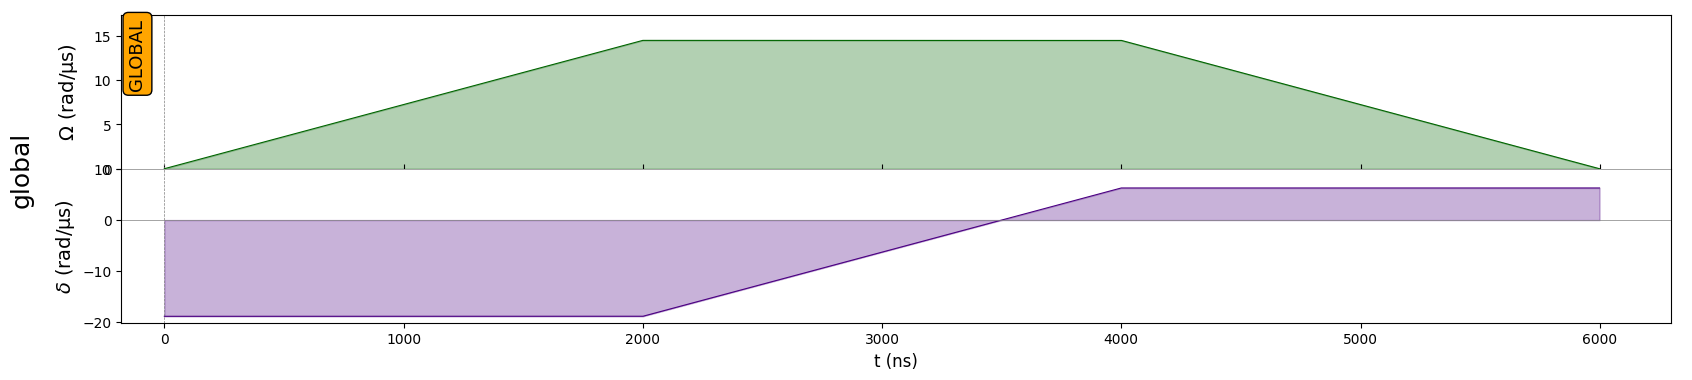

In [3]:
rise = pulser.Pulse.ConstantDetuning(
    pulser.RampWaveform(t_rise, 0.0, Omega_max), delta_0, 0.0
)
sweep = pulser.Pulse.ConstantAmplitude(
    Omega_max, pulser.RampWaveform(t_sweep, delta_0, delta_f), 0.0
)
fall = pulser.Pulse.ConstantDetuning(
    pulser.RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0
)

seq = pulser.Sequence(reg, pulser.MockDevice)
seq.declare_channel("global", "rydberg_global")

seq.add(rise, "global")
seq.add(sweep, "global")
seq.add(fall, "global")

seq.draw()

### 1. Running an emulation

First, we need to initialize the desired observables, their evaluation times, and the basis. 
In this example we chose the final state and the occupation $\langle n_i \rangle$ profile.

In [4]:
from emu_sv import StateResult, SVConfig, Occupation

dt = 10  # timestep in ns
seq_duration = seq.get_duration()

eval_times = [t/seq_duration for t in range(dt, seq_duration, dt)]
final_time = eval_times[-1]

density = Occupation(evaluation_times=eval_times)
state = StateResult(evaluation_times=[final_time])  # get the state at final time

config = SVConfig(dt=dt, observables = [density, state], log_level=2000)


As a next step, we initialize the state vector backend.

To run the simulation, we use the `SVBackend` passing the sequence and the config with the obserservables that we have created before. It returns a `Results` object, which will allow the study or post-processing of the states for each time step in our simulation.

In [5]:
from emu_sv import SVBackend

bknd = SVBackend(seq, config=config)
results = bknd.run()

### 2. Using the `Results`

The `Results` object returned at the end of an emulation run, is a dictionary that contains the observables defined above, at each time step. 
We can access them using their name and time.
The `Results` object that we created contains the final quantum state for example:

In [6]:
last_elem = -1
results.state[last_elem].vector[:10]

tensor([-2.2128e-05+0.0002j,  8.0325e-04-0.0002j,  8.0325e-04-0.0002j,
        -7.4170e-04+0.0004j,  8.0325e-04-0.0002j, -1.6267e-03-0.0034j,
        -7.4170e-04+0.0004j,  7.1285e-04-0.0003j,  8.0325e-04-0.0002j,
        -2.7327e-03-0.0029j], device='cuda:0', dtype=torch.complex128)

We can sample the final state directly, using its `sample()` method from the `Results` object. 
For example, we sample it and discard the less frequent bitstrings:

<BarContainer object of 14 artists>

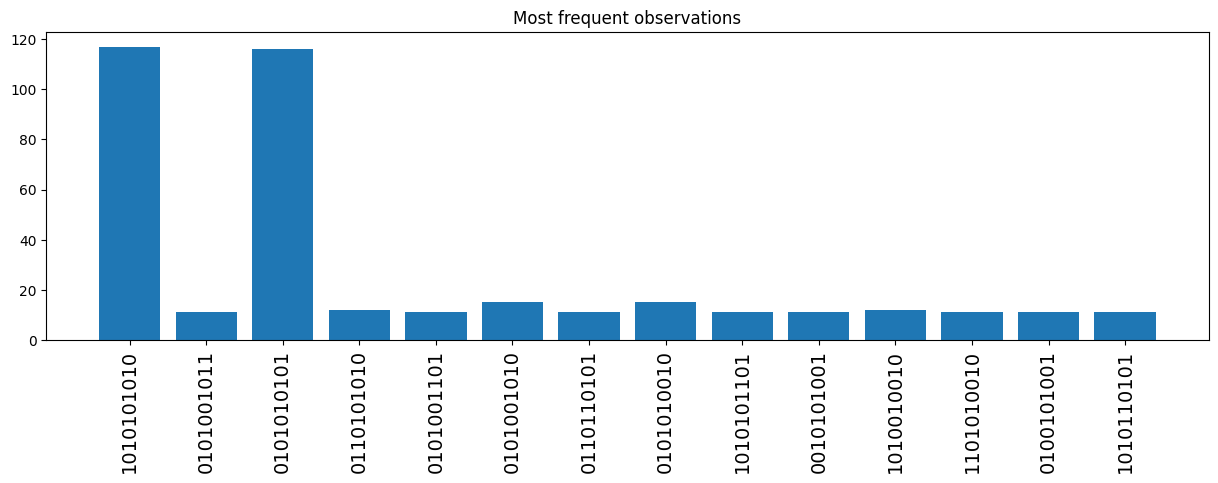

In [7]:
last_elem = -1
final_state = results.state[last_elem]

counts = final_state.sample(num_shots=1000)

large_counts = {k: v for k, v in counts.items() if v > 10}

plt.figure(figsize=(15, 4))
plt.xticks(rotation=90, fontsize=14)
plt.title("Most frequent observations")
plt.bar(large_counts.keys(), large_counts.values())

Notice how the most frequent bitstrings correspond to the antiferromagnetic order states.

We can also get the expectation values of operators for the states in the evolution.
Since we asked for the occupation number $\langle n_i \rangle$ (the Rydberg state population) in the config, we can plot its time evolution on each atom.

/tmp/ipykernel_264286/509801639.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  array_of_occup = [np.array(results.occupation[i])  for i, t in enumerate(times)]


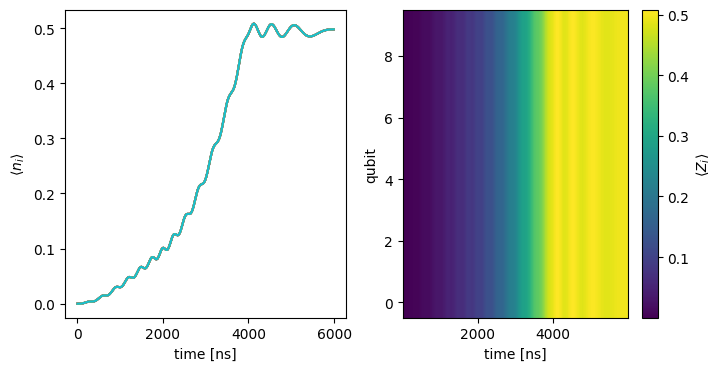

In [8]:
times = np.array(eval_times)*seq.get_duration()
#
array_of_occup = [np.array(results.occupation[i])  for i, t in enumerate(times)]
occup = np.stack(array_of_occup, axis=1)

fig, axs = plt.subplots(1,2, figsize=(8,4))

for i in range(L):
    axs[0].plot(times[0:], occup[i,:])
axs[0].set_xlabel("time [ns]")
axs[0].set_ylabel(r"$\langle n_i\rangle$")

pc = axs[1].pcolor(times, range(L), occup)
axs[1].set_xlabel("time [ns]")
axs[1].set_ylabel("qubit")
fig.colorbar(pc, ax=axs[1], label = r"$\langle Z_i\rangle$")

Notice how the local occupation $\langle n_i \rangle$ on each atom goes in the same way from 0 (which corresponds to the ground state) to 1/2. This is expected since as we saw above, the state after the evolution has antiferromagnetic-order, so at each site, there is a compensation of occupation. The parity (even) and the boundary conditions (periodic) allow for two lowest-energy states, whose superposition is similar to that of the perfectly antiferromagnetic state: $\left( |rgrg\dots\rangle+|grgr\dots\rangle \right)/\sqrt{2}$